<a href="https://colab.research.google.com/github/MagnusXu/cisc6210nlp/blob/master/TF_NN_bigram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Implementation with Tensorflow


## Part 1. Packages

In [2]:
import numpy as np
import random
from datetime import datetime
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [0]:
from nltk.corpus import brown

In [0]:
!pip uninstall tensorflow

Uninstalling tensorflow-1.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-1.15.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.15.0


In [0]:
!pip install tensorflow==2.0.0-beta1

     |████████████████████████████████| 87.9MB 85kB/s 
     |████████████████████████████████| 501kB 44.9MB/s 
     |████████████████████████████████| 3.1MB 56.2MB/s 


In [3]:
import tensorflow as tf
print(tf.__version__)

1.15.0


## Part 2. Data Preprocessing

In [4]:
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [5]:
print(brown.categories())
print(brown.words(categories='news'))

['adventure', 'belles_lettres', 'editorial', 'fiction', 'government', 'hobbies', 'humor', 'learned', 'lore', 'mystery', 'news', 'religion', 'reviews', 'romance', 'science_fiction']
['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', ...]


In [6]:
source_text = brown.words()
print(len(set(source_text)))
print(len(source_text))

56057
1161192


In [7]:
tags = set([
    tag for sentence in brown.tagged_sents() 
    for _, tag in sentence
])
print('nb_tags: %sntags: %s' % (len(tags), tags))

nb_tags: 472ntags: {'FW-RB-TL', 'FW-PP$-NC', 'FW-PP$-TL', 'BEM*', 'NR-HL', 'PPSS+BEZ', 'WRB+BEZ', 'DO*', 'TO+VB', '*-HL', 'DOZ-TL', 'DO-NC', 'NN$', 'CS-NC', 'JJS', 'ABX', 'FW-VBN', '*-TL', 'FW-CC', 'PP$$', 'HV-TL', 'PPO', 'VBZ-TL', 'BEZ-NC', 'ABN-TL', 'FW-NN$', 'UH-HL', 'IN-HL', 'RB-NC', 'NN+IN', 'CD-TL-HL', 'PPSS+MD-NC', 'HV*', 'QLP', 'WRB+IN', 'HV+TO', 'WPS+HVZ', '(', 'NR$', ':', 'FW-NPS', '``', 'WPO', '.-HL', 'NNS-NC', 'BER', 'JJR', ',-HL', 'FW-JJR', 'NN-TL-NC', 'RBR+CS', 'VB-NC', 'BEZ*', 'RP', 'CD-NC', 'NP+HVZ-NC', 'PPSS-NC', 'JJ+JJ-NC', 'FW-CD-TL', 'PPSS+BER-NC', 'PPS', 'NN-NC', 'FW-NNS-NC', 'NN-TL-HL', 'WPS+MD', 'FW-VBG', 'NP+BEZ-NC', 'DO+PPSS', 'RB-TL', 'FW-VB-NC', 'FW-NN-TL-NC', '---HL', 'DOD-NC', 'DT+BEZ-NC', 'PPO-HL', 'VB', 'FW-UH', 'WP$', 'VB+AT', 'JJR-NC', 'NR', 'NR-TL-HL', 'EX+HVZ', 'VBN-NC', 'RP-TL', 'BEDZ-HL', 'BEDZ', 'BE-HL', 'FW-UH-TL', 'UH', 'NNS+MD', 'WRB+DOD*', 'FW-CD', 'MD-HL', 'FW-PN', 'IN-TL-HL', 'HVN', 'WPS+BEZ', 'DOD', 'PN-HL', 'FW-VB', 'FW-VB-TL', 'WRB+BER', '

#### Bigram Tagging

In [0]:
brown_tagged_sents = brown.tagged_sents()

In [9]:
brown_sents = brown.sents()
bigram_tagger = nltk.BigramTagger(brown_tagged_sents)
bigram_tagger.evaluate(brown_tagged_sents)

0.8224660521257466

#### Seperate the train and test data

In [10]:
size = int(len(brown_tagged_sents) * 0.75)
print(size)
train_sents = brown_tagged_sents[:size]
test_sents = brown_tagged_sents[size:]
bigram_tagger = nltk.BigramTagger(train_sents)
bigram_tagger.evaluate(brown_tagged_sents)

43005


0.7034237232085649

In [0]:
from collections import Counter

def build_dict(words, vocabulary_size):
    vocabulary_counts = [('UNK',None)]+Counter(words).most_common(vocabulary_size-1)
    vocabulary = np.array([word for word, _ in vocabulary_counts]) #the second is its counts
    dictionary = {word:code for code, word in enumerate(vocabulary)} #dic is word:index pair
    data = np.array([dictionary.get(word,0) for word in words]) #unk is zero
    reversed_dict = dict(zip(dictionary.values(),dictionary.keys()))
    return data, vocabulary_counts, vocabulary, dictionary, reversed_dict

In [0]:
vocabulary_size = 2000
data, vocabulary_counts, vocabulary, dictionary, reversed_dict = build_dict(source_text, vocabulary_size)

In [13]:
vocabulary_counts[1]

('the', 62713)

In [14]:
print(len(data))

1161192


In [0]:
from collections import deque

In [0]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index #the left edge of the whole window.
    assert batch_size%num_skips==0
    assert num_skips<= 2 * skip_window
    
    batch = np.ndarray(shape=[batch_size], dtype=np.int32)#for input, row vector
    labels = np.ndarray(shape=[batch_size,1], dtype=np.int32)#for output, column vector
    span = 2*skip_window+1 #[skip window target skip window], word context window
    buffer = deque(maxlen=span)#a container could append on both ends
    #print(f"span is {span}")
    for _ in range(span):
        buffer.append(data[data_index])#start from data at data_index
        data_index=(data_index+1)%len(data)#increase but don't overflow
    ## when data_index = 0, skip_window = 2
    ## index     0  1 2  3  4
    ##buffer =  l1 l2 t r1 r2
    #print(f"buffer is {buffer}")
    
    for i in range(batch_size//num_skips):#half of batch_size since num_skips=2
        target=skip_window #target label at the center of buffer
        targets_to_avoid=[skip_window]# to avoid the target
    #    print(f"{i}:{targets_to_avoid}")
        for j in range(num_skips):
     #       print(f"j={j}: ")
            while target in targets_to_avoid:
      #          print(f'target in avoid group:{target}')
                target = np.random.randint(0,span)
       #         print(f"target becomes {target}")
            targets_to_avoid.append(target)
        #    print(f"targets to avoid {targets_to_avoid}")
            batch[i*num_skips+j]=buffer[skip_window]
         #   print(f"batch[{i*num_skips+j}]={buffer[skip_window]}")
            labels[i*num_skips+j,0]=buffer[target]
        
        buffer.append(data[data_index])#push out one word
        data_index=(data_index+1)%len(data)
        #print(f"buffer = {buffer}")
    ##when num_skips = 2, batch_size=4
    ## batch  = t1, t1, t1, t1
    ## labels = l1, l2, r1, r2
    return batch, labels

In [0]:
np.random.seed(8150)

In [17]:
data_index=0
print(f"current data_index = {data_index} and the word is {data[data_index]}:{source_text[data_index]}")
skip_w=2
buffer_size = 2*skip_w+1
print(f'the processed data slice is {data[:buffer_size+data_index]}')
batch, labels=generate_batch(batch_size=4,num_skips=4,skip_window=skip_w)
print(f'input vector is {batch}')
print(f'output vector is \n{labels}')

current data_index = 0 and the word is 15:The
the processed data slice is [  15    0 1281    0    0]
input vector is [1281 1281 1281 1281]
output vector is 
[[15]
 [ 0]
 [ 0]
 [ 0]]


## Part 3. Build and Train Model

In [0]:
from tensorflow.python.framework import ops

def reset_graph(seed=8150):
    ops.reset_default_graph()
    #tf.reset_default_graph()
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [0]:
from tensorflow.python.framework import ops

def reset_graph(seed=8150):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [21]:

reset_graph()
params = tf.constant([[10,20,30,40],[1,2,3,4],[6,7,8,9],[23,24,25,26]])
ids = tf.constant([1,3])
embed = tf.nn.embedding_lookup(params, ids)

#print (embed.numpy())

with tf.Session() as sess:
  print (embed.eval())

[[ 1  2  3  4]
 [23 24 25 26]]


In [22]:
reset_graph()
embeddings = tf.constant([[2.0,3.0,4.0],[1.0,3.0,5.0]])
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings),axis=1,keepdims=True))
normalized_embeddings= embeddings/norm  

#print(norm.numpy())
#print(normalized_embeddings.numpy())

with tf.Session() as sess:
  print(norm.eval())
  print(normalized_embeddings.eval())

[[5.3851647]
 [5.91608  ]]
[[0.37139067 0.55708605 0.74278134]
 [0.16903085 0.50709254 0.8451542 ]]


#### Slide

In [0]:
def word2vec(X,Y,V, learning_rate=0.01, vocabulary_size = 50000, batch_size=128, 
             embedding_size=50, skip_window=1, num_skips=2, 
             neg_num_sampled=64, valid_size= 16, valid_window=100):
    
    with tf.name_scope('word2vec'):
        
               
        with tf.name_scope('embed'):
            #initial values for word embedding for all words
            embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), name='embedding_matrix')
            embed = tf.nn.embedding_lookup(embeddings, X,name='embedding')#word vectors
        
        with tf.name_scope('loss'):
            #nce loss
            nce_weight = tf.get_variable(name='nce_weight', shape=(vocabulary_size, embedding_size),
                        initializer=tf.truncated_normal_initializer(stddev=1.0 / np.sqrt(embedding_size)))
            nce_bias = tf.get_variable(name='nce_bias', initializer=tf.zeros([vocabulary_size]))

            # define loss function to be NCE loss function
            loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weight, #[vocab_size, embedding_size]
                                            biases=nce_bias,         #[vocab_size]
                                            labels=Y,                #[batch_size, 1]
                                            inputs=embed,            #[batch_size, embedding_size]
                                            num_sampled=neg_num_sampled, 
                                            num_classes=vocabulary_size), name='loss')
            
        with tf.name_scope('summary'):
            loss_summary= tf.summary.scalar('loss',loss)
            merged = tf.summary.merge_all()
        
        with tf.name_scope('optimizer'):
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            #optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
        
        with tf.name_scope('valid'):
            norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings),axis=1,keepdims=True))
            normalized_embeddings= embeddings/norm                                 #the output word_embeddings
            valid_embeddings=tf.nn.embedding_lookup(normalized_embeddings,V)
            similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
            
        with tf.name_scope('init'):
            init = tf.global_variables_initializer()
        
    return training_op, loss, normalized_embeddings, similarity, init

In [0]:
vocabulary_size=50000
    
    #build dictionar words
data, vocabulary_counts, vocabulary, dictionary, reversed_dict=build_dict(source_text,vocabulary_size)
    

#We pick a random validation set to sample nearest neighbors.
#we use the most frequent words which have a low numeric id.
valid_size = 16 #random set of words to evaluate similarity on.
valid_window = 100 #only pick dev samples in the head of the distribuiton, word indices, top 100
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
#num_sampled = 64 #number of negative examples to sample

In [26]:
reset_graph()
batch_size=128
data_index=0
train_inputs = tf.placeholder(tf.int32, shape=[batch_size],name='inputs')
train_labels = tf.placeholder(tf.int32, shape=[batch_size,1],name='labels')
valid_dataset = tf.constant(valid_examples,dtype=tf.int32,name='validate')


learning_rate=0.01
embedding_size=50 #dimension of the embedding vector
skip_window=1 # how many words to consider around target word
num_skips = 2 #how many times to reuse an input to generate a label

training_op,loss, final_embeddings, similarity, init= word2vec(train_inputs, train_labels,valid_dataset, 
                                  learning_rate=learning_rate)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [27]:
num_steps = 10001

with tf.Session() as sess:
    sess.run(init)
    #sess.run(tf.global_variables_initializer())
    
    average_loss = 0
    for step in range(num_steps):
        #print(f'Iteration: {step}',end="\t")
        batch_inputs, batch_labels=generate_batch(batch_size, num_skips, skip_window)
        feed_dict={train_inputs: batch_inputs, train_labels: batch_labels}
        
        #we perform one update step by evaluating the training op(including it in the list of returned values for sess.run())
        _, loss_val = sess.run([training_op, loss], feed_dict=feed_dict)
        
        average_loss +=loss_val
        
        if step%200 ==0:
            if step >0:
                average_loss/=200
            #the average loss is an estimate of the loss over the last 2000 batches
            print(f'Average loss at step {step}: {average_loss}')
            average_loss=0
            
    f_embeddings= final_embeddings.eval()

Average loss at step 0: 313.10333251953125
Average loss at step 200: 276.8052930450439
Average loss at step 400: 274.4121969604492
Average loss at step 600: 269.59430068969726
Average loss at step 800: 265.13480781555177
Average loss at step 1000: 262.0832052612305
Average loss at step 1200: 260.49146766662597
Average loss at step 1400: 254.6462216949463
Average loss at step 1600: 251.44075538635255
Average loss at step 1800: 248.49222999572754
Average loss at step 2000: 242.15228607177735
Average loss at step 2200: 240.51701881408692
Average loss at step 2400: 237.59858863830567
Average loss at step 2600: 236.14155433654784
Average loss at step 2800: 236.72615867614746
Average loss at step 3000: 234.9101392364502
Average loss at step 3200: 234.2081382751465
Average loss at step 3400: 229.22899116516112
Average loss at step 3600: 228.33121459960938
Average loss at step 3800: 226.0841081237793
Average loss at step 4000: 221.83660415649413
Average loss at step 4200: 220.15153854370118
Av

In [0]:
np.save("./my_final_embeddings.npy", f_embeddings)

In [29]:
type(f_embeddings)

numpy.ndarray

In [30]:
f_embeddings[0]

array([ 0.08538543, -0.22012815,  0.23030978,  0.12598462,  0.18655983,
       -0.06729643, -0.14960858,  0.16819799, -0.16585818,  0.25496954,
        0.06140701, -0.13597853, -0.25700292,  0.16860063, -0.00342945,
        0.10822809,  0.09226105,  0.18555777, -0.17510778,  0.14632791,
       -0.04237008,  0.01816081,  0.05769961,  0.06643141, -0.12273761,
        0.01990365,  0.0297936 , -0.1010557 ,  0.2284875 ,  0.04906988,
       -0.07011926,  0.13179941, -0.09625489,  0.19519708, -0.04809479,
        0.07432756,  0.08572074,  0.07658234, -0.17853823, -0.1955371 ,
       -0.13535595, -0.10840882, -0.01922591,  0.22131851, -0.22873367,
        0.19016095, -0.01718559,  0.07369018,  0.19461283, -0.07725497],
      dtype=float32)

In [0]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0]>= len(labels),"More labels than embeddings"
    plt.figure(figsize=(20,20))#inches
    for i , label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x,y)
        plt.annotate(label,xy=(x,y), xytext=(5,12), textcoords='offset points', ha='right', va='bottom')

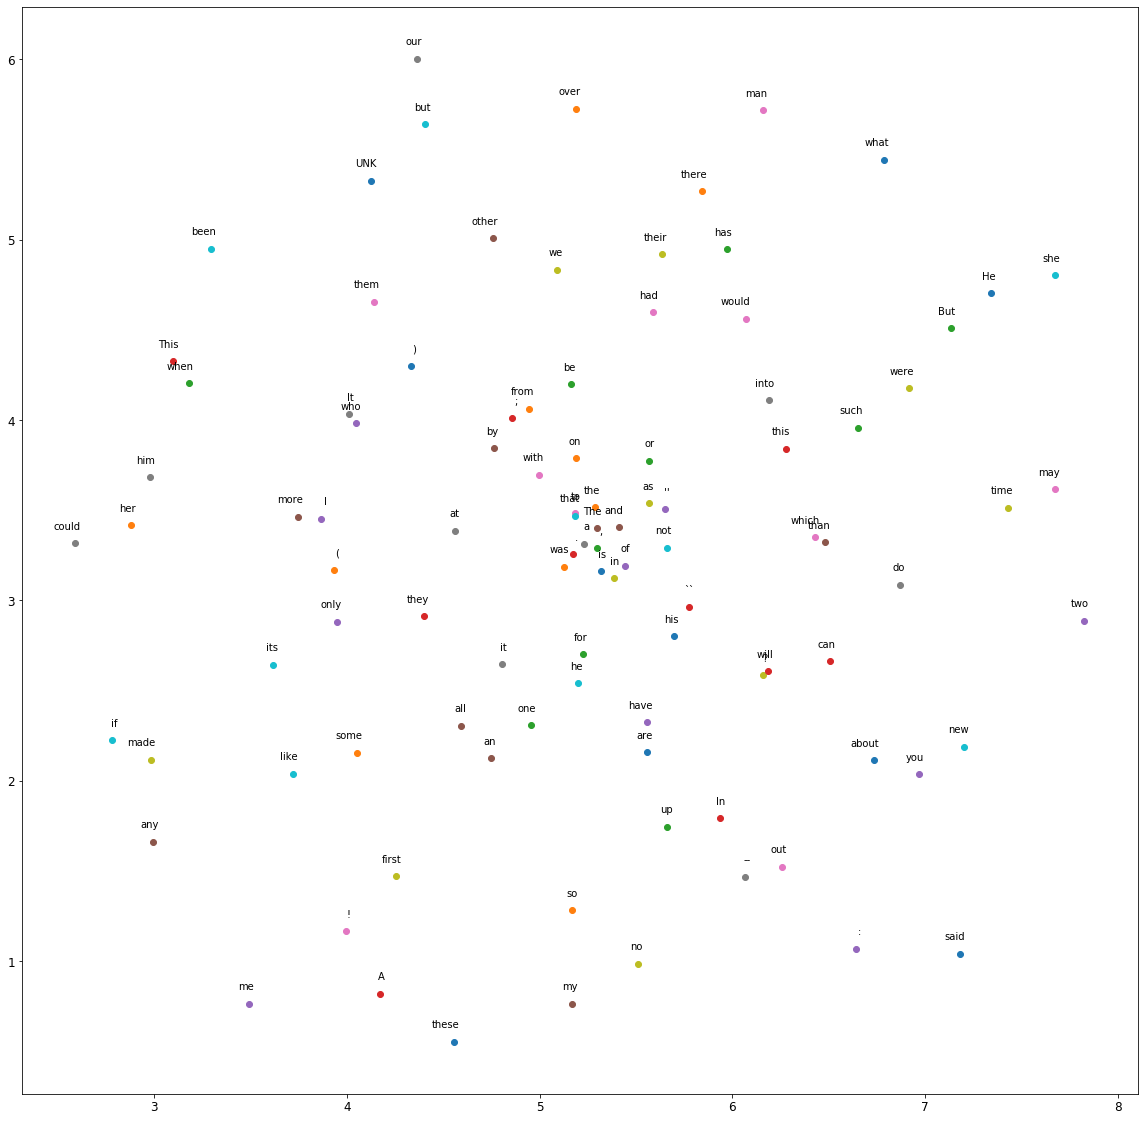

In [32]:
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize']=30
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only=100
low_dim_embs=tsne.fit_transform(f_embeddings[:plot_only,:])
#low_dim_embs = tsne.fit_transform(f_embeddings[plot_only:plot_only*2,:])
labels=[vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

#### Tensorflow blog

In [0]:
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds

In [0]:
encoder = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    source_text, target_vocab_size=2**15)

In [0]:
nltk.download('averaged_perceptron_tagger')
from nltk.tag import PerceptronTagger
train_tag = PerceptronTagger()
train_tag.train(tuple(train_sents))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [0]:
test_tag = PerceptronTagger()
test_tag.train(tuple(test_sents))

In [0]:
padded_shapes = ([None],())
train_batches = train_tag.shuffle(1000).padded_batch(10, padded_shapes = padded_shapes)
test_batches = test_tag.shuffle(1000).padded_batch(10, padded_shapes = padded_shapes)

AttributeError: ignored